In [1]:
import sys
import math
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

#Solved
def linesearch(n, x, deltasol):
    obj_value = np.inf
    for h in range(1001):
        value = myfunction(x + (h/1000)*deltasol)
        if obj_value > value:
            obj_value = value
            s = h
    x += (s/1000.0)*deltasol
    return

#Solved
def myfunction(x):
    coefficient = 1.0
    obj_value = 0.0
    for i in range(len(x)):
        if x[i]:
            coefficient *= 1 - alpha*(x[i]**pi)
            obj_value += coefficient*x[i]
    return -obj_value

#Solved
def partial_derivative_simulation(x, index):
    delta = 1e-06
    x[index] += delta
    Increment = myfunction(x)
    x[index] -= delta
    Origin = myfunction(x)
    return (Increment - Origin)/delta

#Solved, 1st way to compute gradient, simulation
# def compute_gradient(gradient, x):
#     for index, value in enumerate(x):
#         gradient[index] = partial_derivative_simulation(x, index)
# #     print ("gradient is:", gradient)
#     return

#Solved, 2nd way to compute gradient, definition
def compute_gradient(gradient, x):
    item_ni = np.zeros(T)
    coefficient_ni = np.zeros(T)
    coefficient = 1.0
#   pre calculation
    for i in range(T):
        coefficient_ni[i] = 1 - alpha*(x[i]**pi)
        coefficient *= coefficient_ni[i]
        item_ni[i] = coefficient*x[i]
#   formal calculation
    for index, value in enumerate(x):
        if value == 0:
            value = 1e-08
        A = 1 - alpha*(pi+1)*(value**pi)
        # B couldn't be computed when value equals to 0.
        B = -alpha*pi*(value**(pi-1))
        C = 1
        for j in range(index):
            C *= coefficient_ni[j]
        D = np.sum(item_ni[index+1:])
        D /= coefficient_ni[index]
        gradient[index] = A*C + B*D
    print ("gradient is:", gradient)
    return

#Solved
def step_computation(n, x, gradient):
    m = Model("step_search")
    m.ModelSense = 1 #minimize
    # Create variables and put into a dictionary
    deltavar = {}
    for j in range(n):
        deltavar[j] = m.addVar(lb = 0-x[j], ub = N-x[j], obj = 1, vtype = GRB.CONTINUOUS, name = "delta_"+str(j))
    # Update model to integrate new variables
    m.update()    
    # Add first constraint
    xpr = LinExpr()
    for j in range(n):
        xpr += deltavar[j]
    m.addConstr(xpr == 0, name="constraint1")
    # Set objective function
    obj = LinExpr()
    for i in range(n):
        obj += gradient[i]*deltavar[i]
    m.setObjective(obj, GRB.MINIMIZE)
    m.update()
    m.write("step.lp")
    m.optimize()

    code = "optimal"
    if m.status == GRB.status.INF_OR_UNBD:
        print('->LP infeasible or unbounded\n')
        code = "inf_or_unbd"
    if m.status == GRB.status.UNBOUNDED:
        print('->LP unbounded\n')
        code = "unbd"
    if m.status == GRB.status.INFEASIBLE:
        print('->LP infeasible\n')
        code = "infeas"

    print(" -> LP optimal, value = %g\n" %(m.objval))

    deltasol = np.zeros(n)
    for j in range(n):
        print ("%s = %g" %(deltavar[j].varname, deltavar[j].x))
        deltasol[j] = deltavar[j].x

    linesearch(n, x, deltasol)
    return

#Main Iteration
def loop(n, x, row1):
    objective_value = np.inf
    gradient = np.zeros(n)
    value_list = []

    for iteration in range(500):
        value = myfunction(x)
        if abs(value-objective_value) <= 1e-08:
            break
        if objective_value > value:
            objective_value = value
        value_list.append(value)
        compute_gradient(gradient, x)
        step_computation(n, x, gradient)
    
    #Plotting the Gradient Descent
    plt.plot(value_list, 'r-')
    plt.xlabel('The number of iterations')
    plt.ylabel('F(x)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return x, -objective_value
    
#Solved
def feasible(n, row1):
    m = Model("feasible")
    m.ModelSense = -1 #maximize
    # Create variables and put into a dictionary
    xvar = {}
    for j in range(n):
        xvar[j] = m.addVar(lb = 0, ub = N, obj = 1, vtype = GRB.CONTINUOUS, name = "x_"+str(j))

    # Update model to integrate new variables
    m.update()

    # add first constraint
    xpr = LinExpr()
    for j in range(n):
        xpr += row1[j]*xvar[j]
    m.addConstr(xpr == N, name="constraint1")

    m.update()
    m.write("feas.lp")
    m.optimize()

    code = "optimal"
    if m.status == GRB.status.INF_OR_UNBD:
        print('->LP infeasible or unbounded\n')
        code = "inf_or_unbd"
    if m.status == GRB.status.UNBOUNDED:
        print('->LP unbounded\n')
        code = "unbd"
    if m.status == GRB.status.INFEASIBLE:
        print('->LP infeasible\n')
        code = "infeas"

    print(" -> LP optimal, value = %g\n" %(m.objval))

    xsol = np.zeros(n)
    for j in range(n):
        print ("%s = %g" %(xvar[j].varname, xvar[j].x))
        xsol[j] = xvar[j].x

    return code, xsol

#Solved
def run():
    # Given T periods to sell the stocks
    # Create arrays for the only ONE constraint
    row1 = np.ones(T, dtype='double')
    # if we know constraints are sparse, store them using numpy or scipy sparse structures
    print ("row1 = ", row1)
    # 1st initialization method, bad, got stuck in the local optimal.
    code, xsol = feasible(T, row1)
    # 2nd initialization method, evenly distributed, good, arrive at the global optimal.
    xsol[:] = N/T
    print ("initial feasible solution = ", xsol)
    # run the 1st-order method and show the results
    selling_strategy, max_revenue = loop(T, xsol, row1)
    print("Given that P0 is 1.0, the max revenue is %f" % max_revenue)
    print("Selling_strategy in the time series is:", selling_strategy)
    
    return selling_strategy

#Solved
if __name__ == '__main__':
    # set input as global variables
    alpha, pi, N, T = 1e-03, 0.5, 10000, 20
    daily_strategy = run()


row1 =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+04, 1e+04]
Presolve removed 0 rows and 19 columns
Presolve time: 0.02s
Presolved: 1 rows, 1 columns, 1 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+04   0.000000e+00   0.000000e+00      0s
       0    1.0000000e+04   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective  1.000000000e+04
 -> LP optimal, value = 10000

x_0 = 0
x_1 = 0
x_2 = 0
x_3 = 0
x_4 = 0
x_5 = 0
x_6 = 0
x_7 = 0
x_8 = 0
x_9 = 0
x_10 = 0
x_11 = 0
x_12 = 0
x_13 = 0
x_14 = 0
x_15 = 0
x_16 = 0
x_17 = 0
x_18 = 0
x_19 = 10000
initial feasible solution =  [500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500.]
gradie

gradient is: [-4.51326132e+04 -5.33322289e+06 -4.51326132e+04 -4.51326132e+04
 -4.51326132e+04 -4.51326132e+04 -4.51326132e+04 -4.51326132e+04
 -4.51326132e+04 -4.51326132e+04 -4.51326132e+04 -4.51326132e+04
 -4.51326132e+04 -4.51326132e+04  8.54313215e-01  8.54548978e-01
  8.53508721e-01  8.52918013e-01  8.52645696e-01  8.52526523e-01]
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 5e+06]
  Bounds range     [7e-13, 1e+04]
  RHS range        [0e+00, 0e+00]
Presolve removed 1 rows and 20 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -5.3332237e+10   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective -5.333223741e+10
 -> LP optimal, value = -5.33322e+10

delta_0 = 0
delta_1 = 10000
delta_2 = 0
delta_3 = 0
delta_4 = 0
delta_5 = 0
delta_6 = 0
delta_7 = 0
del

Given that P0 is 1.0, the max revenue is 9026.722672
Selling_strategy in the time series is: [8.33000000e+03 1.39111000e+03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.32315370e+02 3.87966668e+01
 6.47904335e+00 1.08200024e+00 1.82646317e-01 3.42732993e-02]


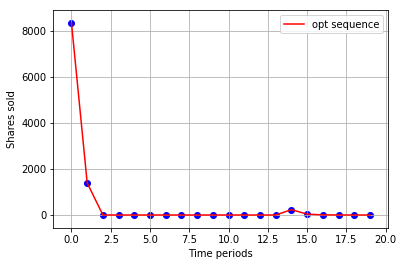

In [2]:
# output the optimal execution in each period
plt.plot(range(T), daily_strategy, 'r-', label='opt sequence')
plt.scatter(range(T), daily_strategy, c='b')
plt.xlabel('Time periods')
plt.ylabel('Shares sold')
plt.legend()
plt.grid(True)
plt.show()
# np.sum(daily_strategy)

In [ ]:
daily_strategy